In [24]:
import os
import pickle
from string import ascii_lowercase, ascii_uppercase
from collections.abc import Iterable

import numpy as np
from jamo import h2j, j2hcj
from tensorflow import reduce_sum
from tensorflow.keras import callbacks, layers, metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences


directory = os.path.dirname(os.path.abspath('test.ipynb'))
path = os.path.join(directory, 'model')

def get_path(filename):
    return os.path.join(path, filename)

if os.path.isfile(get_path('chardict.pkl')):
    with open(get_path('chardict.pkl'), 'rb') as f:
        char_dict = pickle.load(f)

else:
    jaem = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㄲ', 'ㄸ', 'ㅃ', 'ㅆ', 'ㅉ', 'ㄳ', 'ㄵ', 'ㄶ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅄ']
    moem = ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅐ', 'ㅒ', 'ㅔ', 'ㅖ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅢ']
    english = list(ascii_lowercase) + list(ascii_uppercase)
    sign = [s for s in ''' `~!@#$%^&*()+-/=_,.?;:'"[]{}<>\|''']

    link_list = sign + jaem + moem + english + [str(i) for i in range(10)]
    char_dict = {k: code + 2 for code, k in enumerate(link_list)} # 0은 padding, 1은 oov

    with open(get_path('chardict.pkl'), 'wb') as f:
        pickle.dump(char_dict, f, pickle.HIGHEST_PROTOCOL)

vocab_size = len(char_dict) + 2 # padding, OOV 포함!
maxlen = 60


def encode(text: str) -> list:
    """
    하나의 str을 받아와 인코딩합니다. 단, padding 작업은 진행하지 않습니다.

    argument
    text: 인코딩할 문자열입니다.

    return: 인코딩된 리스트를 반환합니다.
    """
    assert isinstance(text, str), "text argument must be str."

    text = j2hcj(h2j(str(text)))
    code = [char_dict.get(t, 1) for t in text]
    return code


def preprocessing(data: Iterable) -> np.ndarray:
    """
    하나의 str 또는 str로 구성된 iterable한 객체을 받아와 인코딩합니다.
    padding 작업과 one-hot-encoding 작업도 진행합니다.

    argument
    text: 인코딩할 문자열 또는 문자열이 담긴 순회가능한 객체입니다.

    return: 인코딩, padding, one-hot-encoding 작업을 거친 3차원 numpy 배열입니다.
    """
    if isinstance(data, str):
        data = [encode(data)]
    elif isinstance(data, Iterable):
        data = [encode(t) for t in data]
    else:
        assert True, "data argument must be str or Iterable object."
    
    data = pad_sequences(data, maxlen)
    
    return to_categorical(data, vocab_size)


def load_badword_model() -> Model:
    """
    학습된 모델을 불러옵니다. 불러온 모델은 compile 작업을 마친 상태입니다.
    
    return: 사전학습된 tf.keras.Model 객체가 compile된 상태로 반환됩니다.
    """
    model = load_model(get_path('model.h5'))
    model.compile(
        loss="binary_crossentropy", 
        optimizer="adam", 
        metrics=[
                 metrics.BinaryAccuracy(name="acc"), 
                 metrics.Recall(name="recall"), 
                 metrics.Precision(name="prec"),
                 ]
                  )
    
    return model

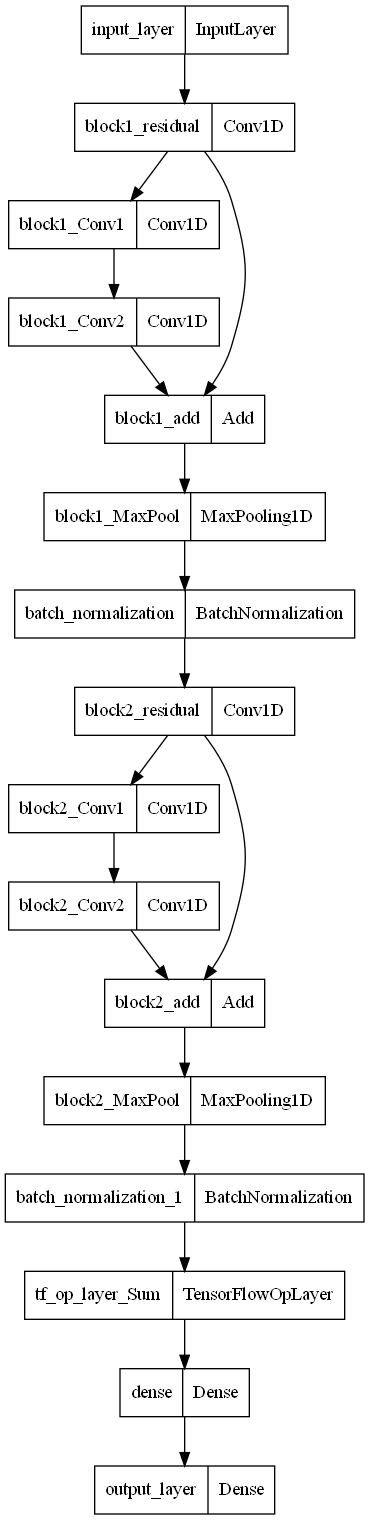

In [25]:


model = load_badword_model()
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', )

In [2]:
import pandas as pd
test = pd.read_csv(r'C:\code\skkukdt_minzy\DeepLearning\data\test_final.csv')

In [3]:
model = load_badword_model()
def pred(data):
    data = preprocessing(data)
    return model.predict(data)

test['pred'] = test['text'].apply(pred)

1/1 [==============================] - 0s 33ms/step


In [ ]:
MAX_SEQUENCE_LENGTH = 100 
test_t = test['text'].apply(lambda x : [char_dict.get(t, 1) for t in j2hcj(h2j(str(x)))])
test_t = pad_sequences(test_t, maxlen=60, padding='pre')


model = load_badword_model()
model.predict(test_t)

In [5]:
# test.to_csv('test_p.csv')

In [11]:
import pandas as pd
test = pd.read_csv(r'test_p.csv')
test

,Unnamed: 0,text,immoral,pred
0,0,명절이면 좀 일찍 마쳐주지,0,[[0.20773704]]
1,1,원래 틀딱들은 눈치가 없어서 ㅋㅋㅋ,0,[[0.12440357]]
2,2,저 나이 먹고 저렇게 눈치 없는 것도 재주다,0,[[0.70227605]]
3,3,요즘은 왜 미세먼지가 별로 없지?,0,[[0.07943837]]
4,4,호주랑 중국이랑 싸우고 있어서 중국에서 호주산석탄을 수입 안해서 그렇대,0,[[0.00075938]]
...,...,...,...,...
46825,46825,클레드로 굶드라랑 월식 못 가게 너프먹는다니까 진짜 ㅈ같아서 겜 못해먹겠네 월식은 ...,1,[[0.07093826]]
46826,46826,진짜 개사기임아니 협곡말고 롤체 학살자 클레드요,0,[[0.03987349]]
46827,46827,진짜 태불방 롤백 시킬거 아니면 클레드는 건들면 안되지 ㅋㅋㅋ 선넘네 진짜,0,[[0.01874321]]
46828,46828,"""바텀에서 겨우 더블킬을 했다.""""나팔소리가 들렸다.""""여름이었다.""(제압되었습니다!)",0,[[0.0009397]]


In [21]:
from sklearn.metrics import classification_report
import numpy as np
test['pred_b'] = np.where(test['pred'] > 0.5, 1, 0)
print(classification_report(test['immoral'], test['pred_b']))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83     41924
           1       0.16      0.38      0.22      4906

    accuracy                           0.73     46830
   macro avg       0.54      0.57      0.53     46830
weighted avg       0.83      0.73      0.77     46830



In [ ]:
def tofloat(data):
    return float(data[2:-2])

test['pred'] = test['pred'].apply(tofloat)

In [23]:
test

,Unnamed: 0,text,immoral,pred,pred_b
0,0,명절이면 좀 일찍 마쳐주지,0,0.207737,0
1,1,원래 틀딱들은 눈치가 없어서 ㅋㅋㅋ,0,0.124404,0
2,2,저 나이 먹고 저렇게 눈치 없는 것도 재주다,0,0.702276,1
3,3,요즘은 왜 미세먼지가 별로 없지?,0,0.079438,0
4,4,호주랑 중국이랑 싸우고 있어서 중국에서 호주산석탄을 수입 안해서 그렇대,0,0.000759,0
...,...,...,...,...,...
46825,46825,클레드로 굶드라랑 월식 못 가게 너프먹는다니까 진짜 ㅈ같아서 겜 못해먹겠네 월식은 ...,1,0.070938,0
46826,46826,진짜 개사기임아니 협곡말고 롤체 학살자 클레드요,0,0.039873,0
46827,46827,진짜 태불방 롤백 시킬거 아니면 클레드는 건들면 안되지 ㅋㅋㅋ 선넘네 진짜,0,0.018743,0
46828,46828,"""바텀에서 겨우 더블킬을 했다.""""나팔소리가 들렸다.""""여름이었다.""(제압되었습니다!)",0,0.000940,0


In [ ]:
parser.add_argument 하는거 변수 선언.
parser.add_argument("--max_seq_len", type = int, default = 128)
변수 이름이 max_seq_len, type은 int, 초기값은 128
인자들을 바꿀 수 있도록 모듈로 만든것. import 할 수 있다.

=> 호출할때 지정해준다
!python train.py --max_seq_len 64 --batch_size 128